<h1> Credit Card Fraud Detection</h1>

![alt fraud](fraud.png)

<h1>Background</h1>

The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


In [2]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

# Additional imports
from ipywidgets import interact, FloatSlider
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from imblearn.under_sampling import TomekLinks


### Data Understanding
The Dataset we use is the Kaggle Credit Card Fraud Detection Dataset enlisted in the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link</a>
- The Data has 32 features from V1-V28 which are unknown for confidentiality, TIme, Amount and Class
- The input features are V1-V28, Time and Amount
- The target variable is Class
- The Data does not have any missing values as evident from the below mentioned code, thus need not be handled
- The Data consists of all numerical features, and only the Target Variable Class is a categorical feature.
    - Class 0: Legitimate Transaction
    - Class 1: Fraud Transaction

In [3]:
# Read Data into a Dataframe
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### Data Preparation

- The Data does not have any missing values and hence, need not be handled.
- The Data has only Target Variable Class as the categorical variable.
- Remaining Features are numerical and need to be only standardized for comparison after balancing the dataset
- The mean of the amount of money in transactions is 88.34
- The standard deviation of amount of money in transactions is 250.12
- The time is distributed throughout the data equitably and hence, serves as an independent feature
- It is best to not remove or drop any data or features in this case and try to tune the model assuming them as independent features initially

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().sum().sum()

0

Check for any missing values in the dataset, confirming data completeness.

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [8]:
fraud = round(len(df[df['Class']==1])/len(df)*100,2)
nofraud = round(len(df[df['Class']==0])/len(df)*100,2)

print("No fraud transactions are:",str(nofraud)+'%',"of the dataset")
print("Fraud transactions are:",str(fraud)+'%',"of the dataset")

No fraud transactions are: 99.83% of the dataset
Fraud transactions are: 0.17% of the dataset


Text(0.5, 1.0, '0: Non-fraudulent 1: Fraudulent')

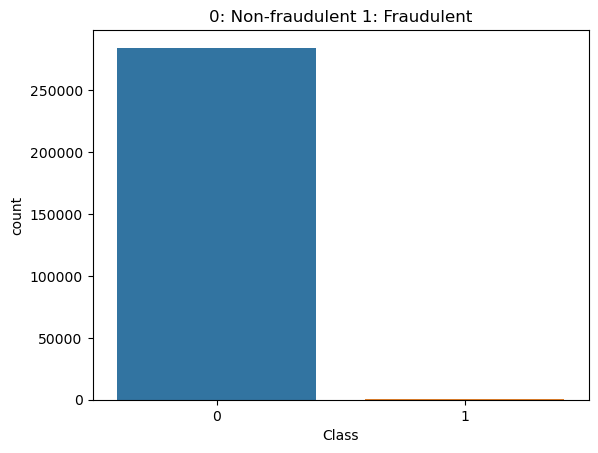

In [9]:
sns.countplot(x='Class',data=df)
plt.title("0: Non-fraudulent 1: Fraudulent")

* The amount variable is mostl dense around the samllar amount regions.

Text(0.5, 1.0, 'Distribution of Amount')

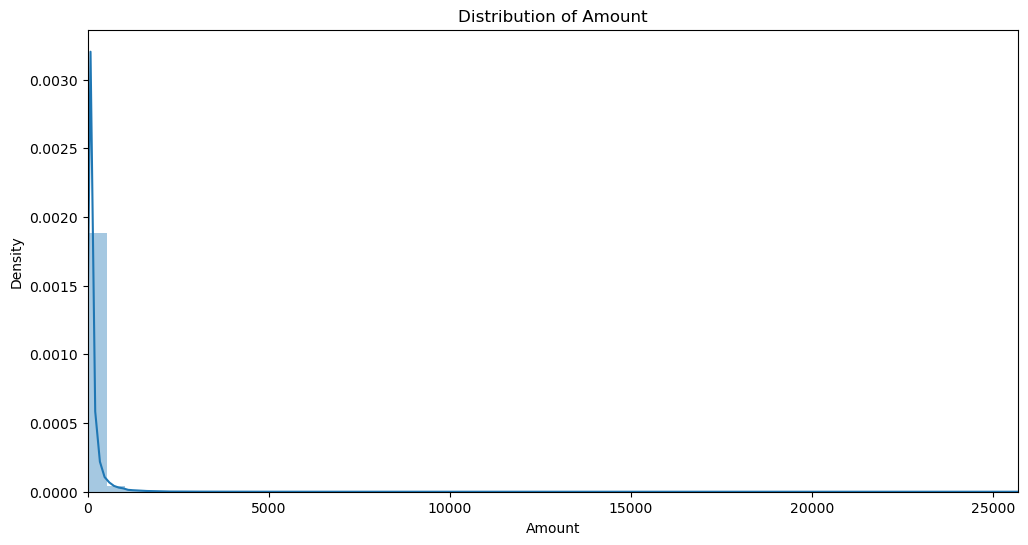

In [10]:
amount_val = df['Amount'].values
plt.figure(figsize = (12,6))
sns.distplot(df['Amount'])
plt.xlim(min(amount_val),max(amount_val))
plt.title("Distribution of Amount")

Time has bimodal distribution i.e. the peak rises and falls down and rises again. The fall might happen due to night time.

Text(0.5, 1.0, 'Distribution of transaction time')

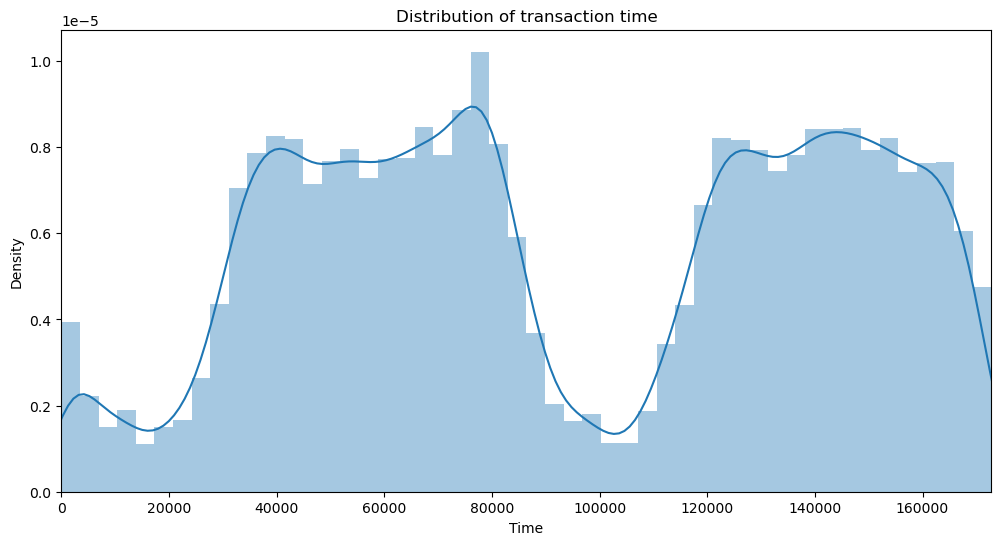

In [11]:
time_val = df['Time'].values
plt.figure(figsize=(12,6))
sns.distplot(df['Time'])
plt.xlim(min(time_val),max(time_val))
plt.title("Distribution of transaction time")

And similarly we have plotted all our features individually and the intersting inferences from them are listed below

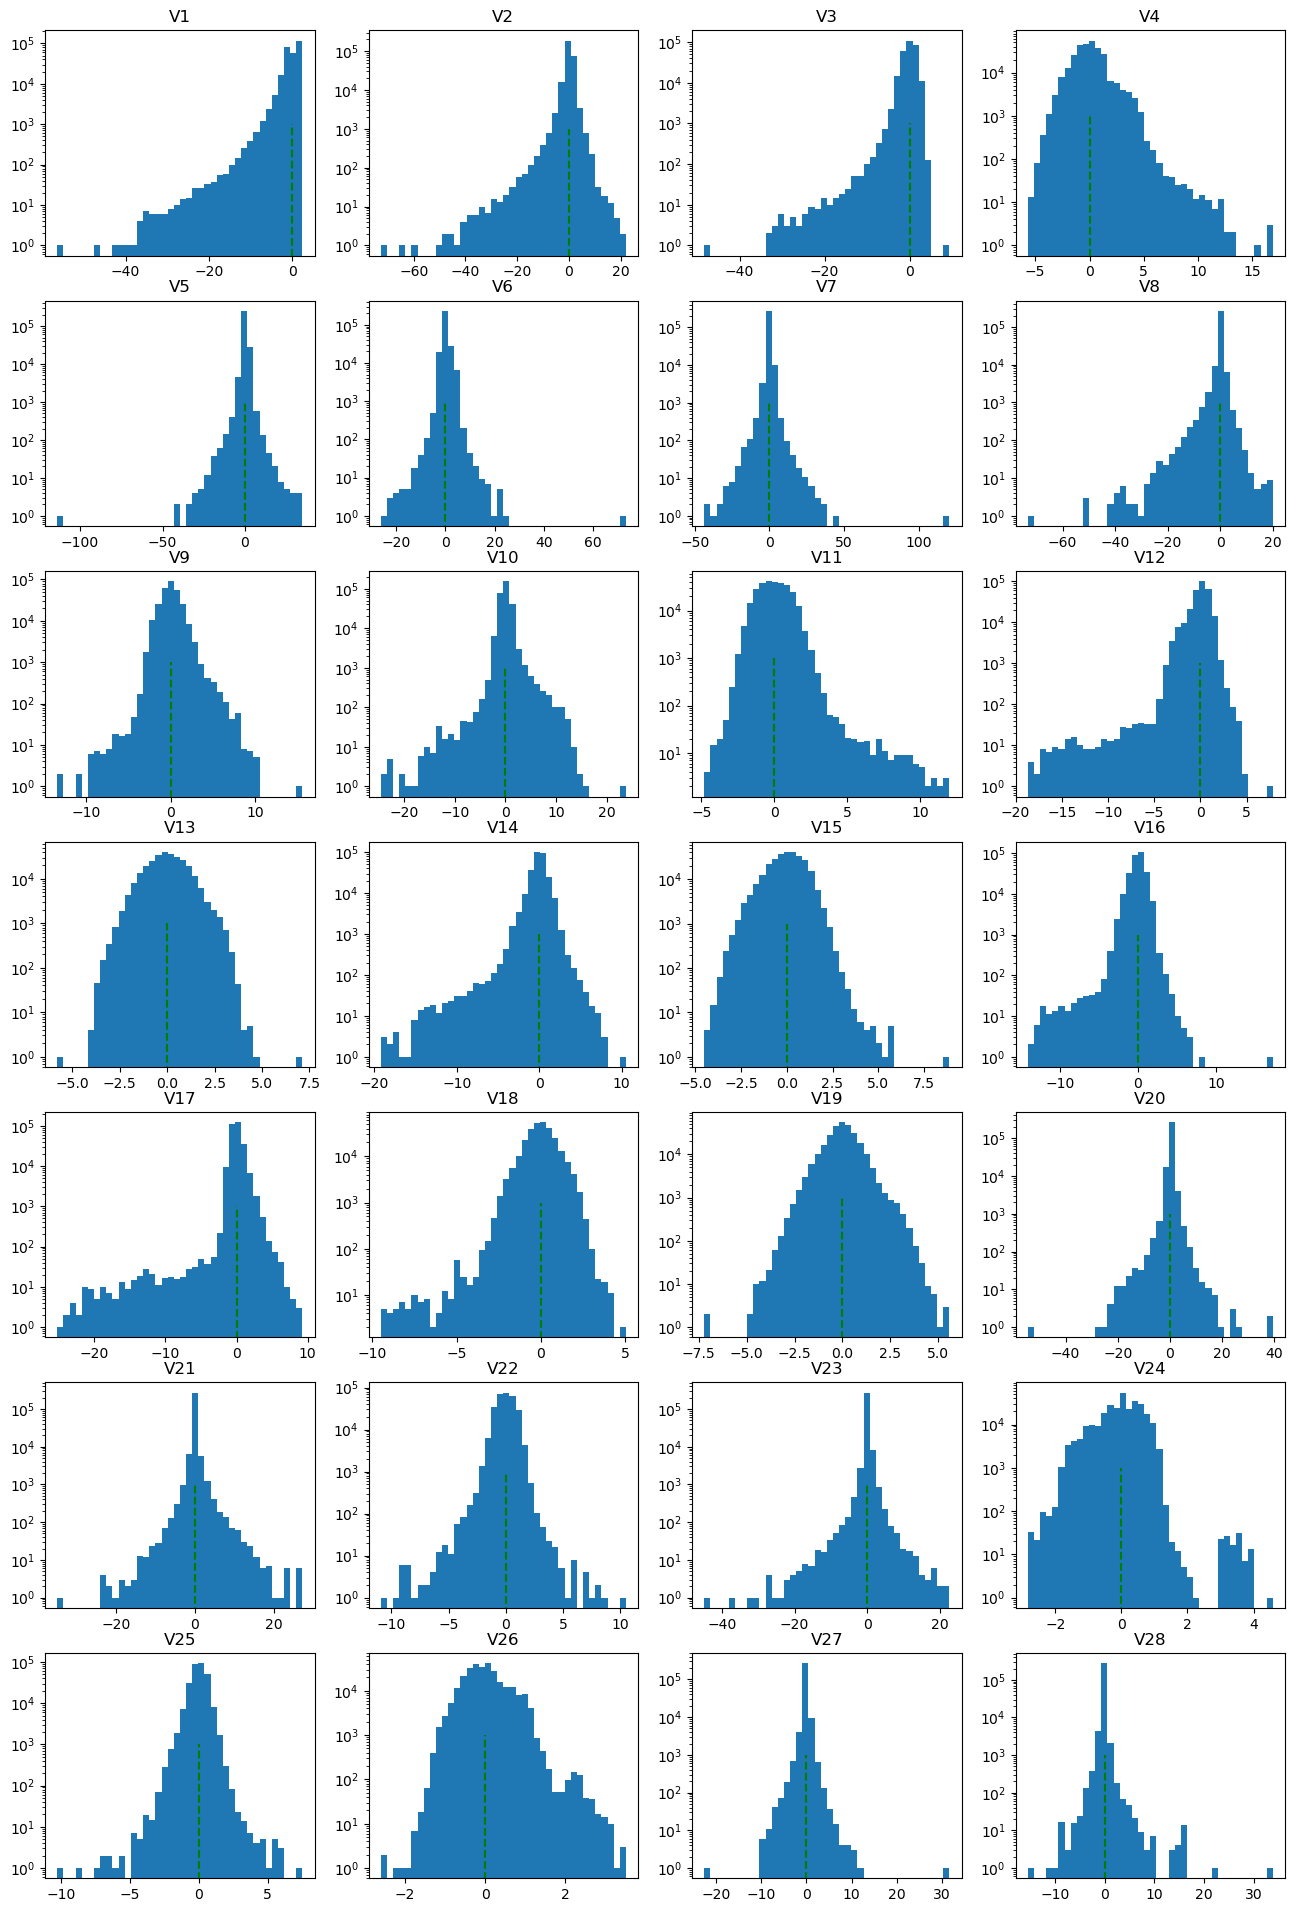

In [12]:
#distribution of the different features

fig, ax = plt.subplots(nrows=7,ncols=4,figsize=(16,24))

for i in range(1,29):
  m = (i-1)//4
  n = (i-1)%4
  col = 'V' + str(i)
  ax[m,n].hist(df[col],bins=40)
  ax[m,n].set_title(col)
  ax[m,n].vlines(x=df[col].mean(),ymin=0,ymax=10**3,linestyle='dashed',colors='g')
  ax[m,n].set_yscale('log')

BIVARIATE ANALYSIS

Bivariate analysis content

It can be cleared observed that there are very less data points having amount greater than 10,000(all in the non-fraudulent category), hence we can exclude these from our dataset.

Text(0.5, 1.0, 'Amount vs Class')

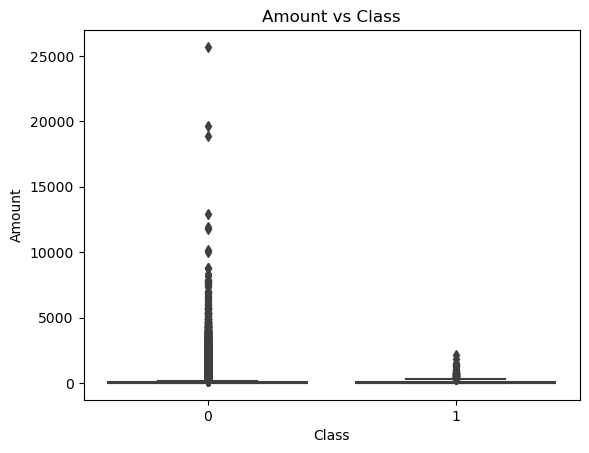

In [13]:
#class vs amount
sns.boxplot(x='Class',y='Amount',data=df)
plt.title('Amount vs Class')

In [14]:
#checking the above observation
df[df['Amount']>10000]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
46841,42951.0,-23.712839,-42.172688,-13.320825,9.925019,-13.945538,5.564891,15.710644,-2.844253,-1.580725,...,7.921600,-6.320710,-11.310338,0.404175,-4.547278,-1.577118,-2.357385,2.253662,12910.93,0
54018,46253.0,-21.780665,-38.305310,-12.122469,9.752791,-12.880794,4.256017,14.785051,-2.818253,-0.667338,...,7.437478,-5.619439,-10.547038,0.653249,-4.232409,-0.480459,-2.257913,2.082488,11898.09,0
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0
169457,119713.0,-20.924897,-37.943452,-14.060281,10.473005,-10.866639,6.256654,14.960521,-2.392155,-0.597076,...,6.829810,-6.926353,-9.928657,-0.447084,-4.848151,-2.241620,-2.140723,2.001492,11789.84,0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,...,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0


In [15]:
#excluding the above mentioned points
df = df[df['Amount']<10000]
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,...,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000,284799.000000
mean,94813.586235,0.000716,0.001123,0.000542,-0.000326,0.000800,-0.000436,-0.000897,0.000198,0.000045,...,-0.000100,0.000140,0.000326,-0.000027,0.000103,0.000019,-0.000073,0.000008,87.927043,0.001728
std,47488.019368,1.953489,1.635632,1.511555,1.414375,1.359939,1.324170,1.210706,1.193066,1.098578,...,0.732325,0.724703,0.618721,0.605586,0.520394,0.482084,0.399034,0.328549,235.414278,0.041528
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-8.887017,-44.807735,-2.836627,-10.295397,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,54202.500000,-0.920290,-0.598457,-0.890240,-0.848660,-0.691546,-0.768299,-0.554089,-0.208605,-0.643083,...,-0.228395,-0.542320,-0.161841,-0.354593,-0.317128,-0.326979,-0.070835,-0.052960,5.590000,0.000000
50%,84691.000000,0.018158,0.065524,0.179859,-0.019921,-0.054322,-0.274227,0.040079,0.022363,-0.051416,...,-0.029452,0.006795,-0.011191,0.040964,0.016607,-0.052124,0.001343,0.011243,22.000000,0.000000
75%,139320.000000,1.315648,0.803743,1.027212,0.743302,0.611927,0.398463,0.570385,0.327356,0.597164,...,0.186367,0.528554,0.147642,0.439524,0.350716,0.240952,0.091045,0.078277,77.150000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.491217,34.801666,22.529298,36.877368,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,8790.260000,1.000000


In [16]:
#amount vs time distribution

data_new = df
timedelta = pd.to_timedelta(data_new['Time'],unit='s')

data_new['Time_min'] = (timedelta.dt.components.minutes).astype(int)
data_new['Time_hour'] = (timedelta.dt.components.hours).astype(int)

So as we can see transactions both fraud and legitimate are more or less uniformly distributed throughout Time_min.

Text(0.5, 1.0, 'Amounts by Minutes of Frauds and Normal Transactions')

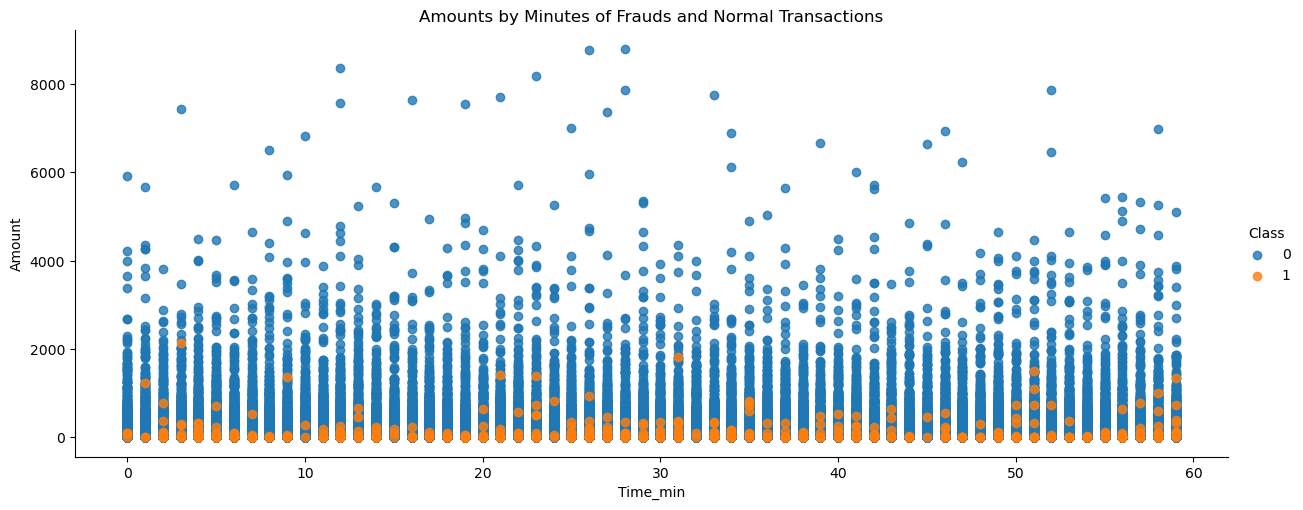

In [17]:
ax = sns.lmplot(y='Amount',x='Time_min',fit_reg=False,aspect=2.5,data=data_new,hue='Class')
plt.title("Amounts by Minutes of Frauds and Normal Transactions",fontsize=12)

Now transactions show a more non uniform disribution accross Time_hour which makes sense but still we see no particular pattern to distinguish fraud and non-fraud from this analysis, non-fraud volume is more on active hour compared to lean hours.

Text(0.5, 1.0, 'Amounts by hours of Frauds and Normal Transactions')

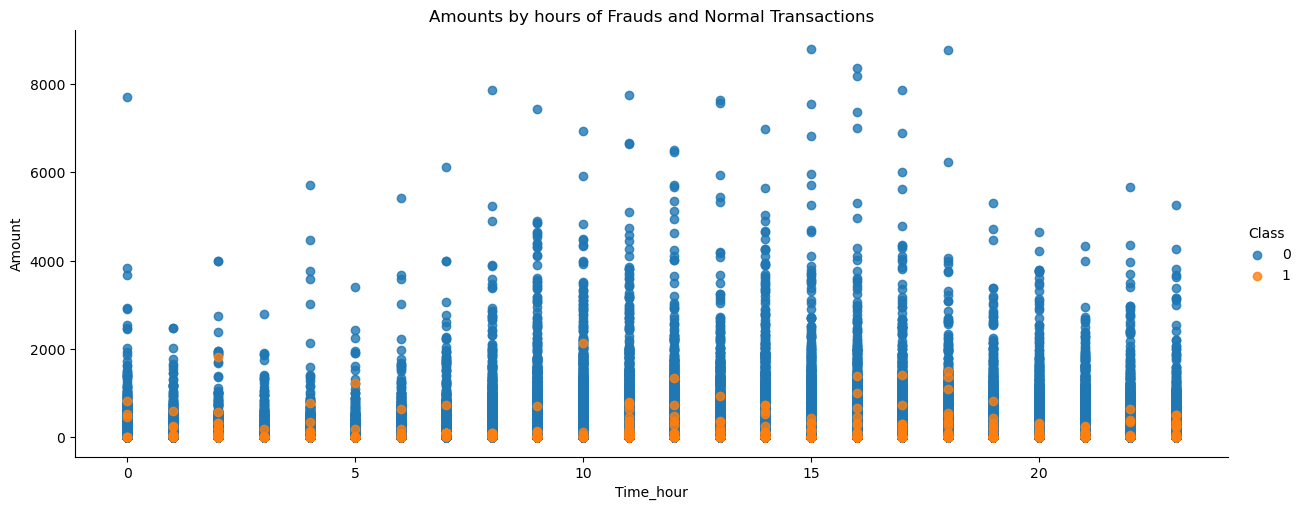

In [18]:
ax = sns.lmplot(y='Amount',x='Time_hour',fit_reg=False,aspect=2.5,data=data_new,hue='Class')
plt.title("Amounts by hours of Frauds and Normal Transactions",fontsize=12)

This confirms the pattern oberserved above about non-fraud and also shows that fraud transactions are much more uniform accorss the day.

(-1.0, 25.0)

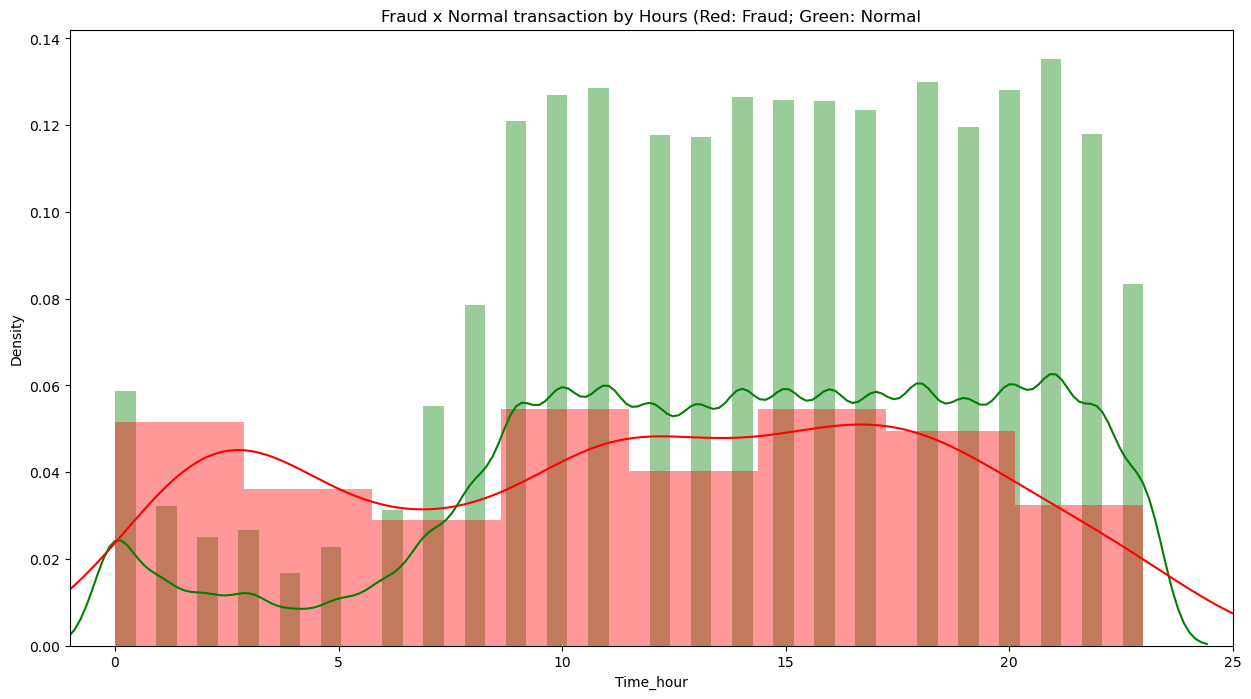

In [19]:
plt.figure(figsize=(15,8))
sns.distplot(data_new[data_new['Class']==0]['Time_hour'],color='g')
sns.distplot(data_new[data_new['Class']==1]['Time_hour'],color='r')
plt.title('Fraud x Normal transaction by Hours (Red: Fraud; Green: Normal',fontsize=12)
plt.xlim([-1,25])

<h3>CONCLUSIONS FROM EDA</h3>

The data consisted of around 2,85,000 data points, 30 features including time and amount, and the labeled class of whether a transaction is actually fraud or not.
There were no null values present in the original dataset but the data was highly skewed with 99.83% of the data points being non-fraudulent transactions.
The time feature had a bimodal distribution i.e. peaks falling and rising. we have concluded that the peaks might fall due to lesser transactions during nighttime.
Very small proportion of transactions had amounts > 10,000 hence they were eliminated from the dataset.
Most of the fraudulent transactions were of small amounts (<1000 units - since we don’t know about the units about the currency).
The occurrence of fraudulent transactions was independent of the time of the day.

<h1>Data Preprocessing</h1>

SCALING

Standardization and Robust Scalar

Since fraud transactions which are also low in number have relatively smaller value(amount) so we need to have our data scaled, We are going to use robust scalar to scale our data.

In [20]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Time','Amount'],axis=1,inplace=True)

In [21]:
df.drop(['Time_min','Time_hour'],axis=1,inplace=True)

In [22]:
#inserting these scaled columns at 0,1
scaled_amount = df['scaled_amount']

df.drop(['scaled_amount'],axis=1,inplace=True)
df.insert(0,'scaled_amount',scaled_amount)

df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783399,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269843,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.984069,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418390,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670626,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


SPLITING THE DATASET

Splitting data is the first step to model training and here we are using StratifiedKFold, it maintains the class distribution in training and test data which is much needed in imbalanced distribution like ours.:

In [23]:
from sklearn.model_selection import StratifiedKFold

X = df.drop('Class',axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

for train_index, test_index in sss.split(X,y):
  print("Train:", train_index, "Test:", test_index)
  original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
  original_ytrain, original_ytest = y.iloc[train_index],y.iloc[test_index]

#converting it into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#check if both train and test distributions are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest,return_counts=True)

print("Label dstributions: \n")
print(train_counts_label/len(original_ytrain))
print(test_counts_label/len(original_ytest))

Train: [ 30442  30473  30496 ... 284796 284797 284798] Test: [    0     1     2 ... 57016 57017 57018]
Train: [     0      1      2 ... 284796 284797 284798] Test: [ 30442  30473  30496 ... 113962 113963 113964]
Train: [     0      1      2 ... 284796 284797 284798] Test: [ 80757  81183  81606 ... 170942 170943 170944]
Train: [     0      1      2 ... 284796 284797 284798] Test: [150644 150651 150657 ... 227860 227861 227862]
Train: [     0      1      2 ... 227860 227861 227862] Test: [212511 212639 213087 ... 284796 284797 284798]
Label dstributions: 

[0.99827072 0.00172928]
[0.99827946 0.00172054]


UNDERSAMPLING TO MAKE THE DATASET BALANCED

since our classes are highly skewed, we have to make them equivalent in occurence to have a normal distribution of the classes, shuffle the data before creating the sub-samples.

In [24]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1,random_state=42)

new_df.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
243451,-0.125908,0.260061,0.258934,0.212868,0.280120,-0.676560,-0.527280,-0.537848,0.489117,0.879756,...,-0.220186,0.312092,0.928744,0.103161,-0.104674,-0.646034,-0.200377,-0.066687,-0.149197,0
79525,-0.293460,-2.630598,5.125759,-6.092255,5.527393,1.605145,-2.319884,-3.207076,-1.482583,-5.074871,...,0.948864,-0.527474,0.220546,-1.371110,-0.504899,0.382307,0.395528,0.782036,0.628528,1
126015,-0.293460,1.155894,0.243855,0.554944,1.465218,-0.299576,-0.376393,0.069652,-0.038642,0.262324,...,-0.213376,-0.084153,0.012670,-0.016295,0.409209,0.623611,-0.331808,0.042109,0.018040,0
42473,-0.254472,-3.600544,4.519047,-6.340884,6.214767,-5.829558,-2.478095,-9.938412,2.830086,-5.659162,...,1.384743,2.263770,0.620749,-0.094069,0.536719,0.398142,0.008277,2.053524,0.835749,1
261925,1.872554,-2.783865,1.596824,-2.084844,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,-0.347046,...,-0.515001,0.203563,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,1


In [25]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


CORRELATION HEAT MAP

Correlation is a term used to represent the statistical measure of linear relationship between two variables. It can also be defined as the measure of dependence between two different variables. If there are multiple variables and the goal is to find correlation between all of these variables and store them using appropriate data structure, the matrix data structure is used. Such matrix is called as correlation matrix.

We look at the correlation matrix in original distribution and later used balanced data it shows no much correlation between features or classes for orginal distribution but on balanced set we can visualize correlation more easily, so we find out features highly correlated(positively/negatively) and do outlier detection and removal from them for our data preperation.

Syntax to calculate and see features below or above certain threshold

corr = new_df.corr()
corr[['Class']]
corr[corr.Class<-0.6]['Class']

Text(0.5, 1.0, 'SubSample Correlation Matrix \n (use for reference)')

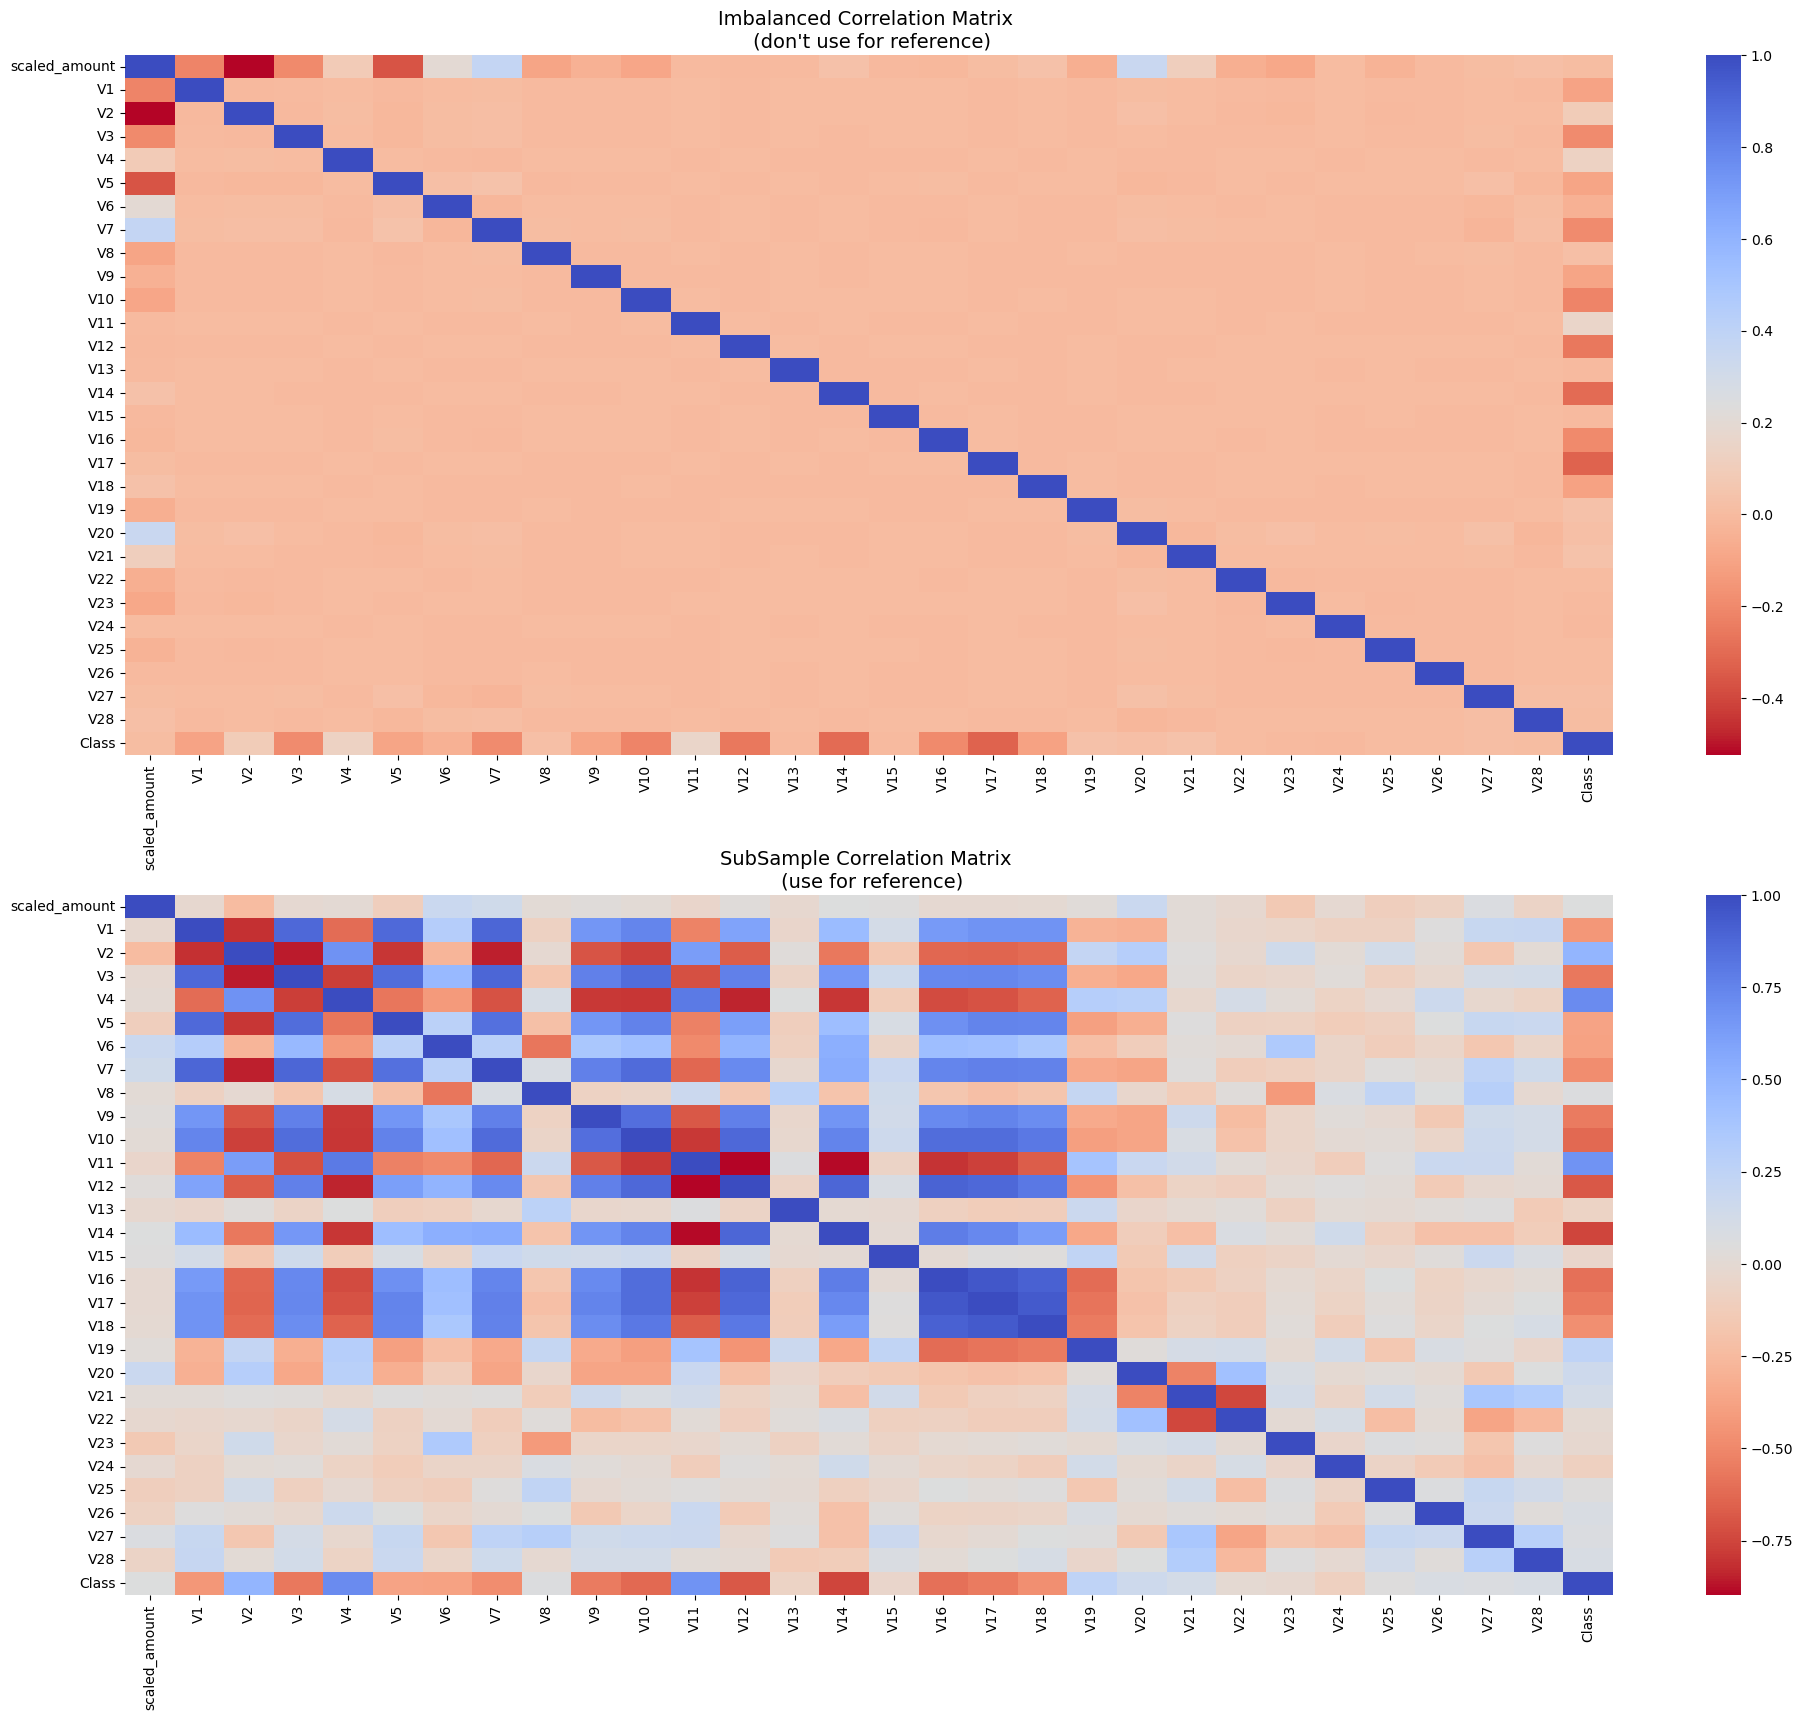

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# comparing correlation between dataset
# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# new_df
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

DETECTING OUTLIERS

In [27]:
corr = new_df.corr()
corr[['Class']]
corr[corr.Class<-0.6]['Class']

V10   -0.628480
V12   -0.687850
V14   -0.749751
Name: Class, dtype: float64

In [28]:
corr = new_df.corr()
corr[['Class']]
corr[corr.Class>0.5]['Class']

V4       0.714218
V11      0.678022
Class    1.000000
Name: Class, dtype: float64

V4, V11 are our highly positively correlated featres and V10, V12, V14 have high negative correlation with class, now we do outlier analysis and removal.

-Negative correlations with our class (the lower the feature value, higher the chances of it being a fraud transaction)

we use seaborn boxplot for our visualization, go ahead and do this yourself in cell below.

f, axes = plt.subplots(ncols=4,figsize=(20,4))

sns.boxplot(x='Class',y='V16',data=new_df,ax=axes[0])
axes[0].set_title('V16 vs Class Negative Correlation')

Text(0.5, 1.0, 'V10 vs Class Negative Correlation')

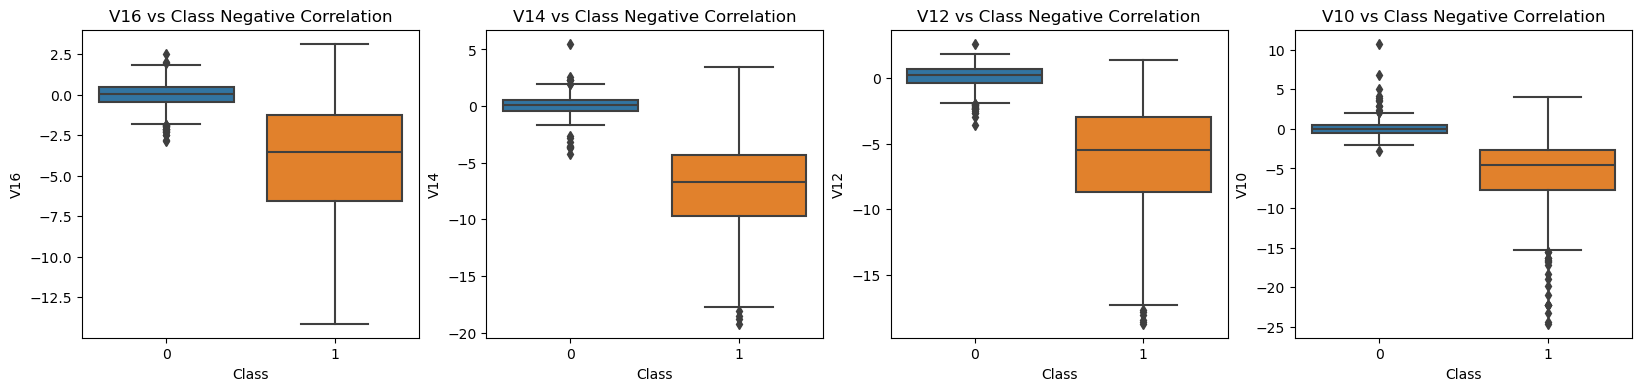

In [29]:
f, axes = plt.subplots(ncols=4,figsize=(20,4))

#Negative correlations with our class (the lower the feature value, higher the chances of it being a fraud transaction)
sns.boxplot(x='Class',y='V16',data=new_df,ax=axes[0])
axes[0].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x='Class',y='V14',data=new_df,ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x='Class',y='V12',data=new_df,ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x='Class',y='V10',data=new_df,ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

Text(0.5, 1.0, 'V4 vs Class Positive Correlation')

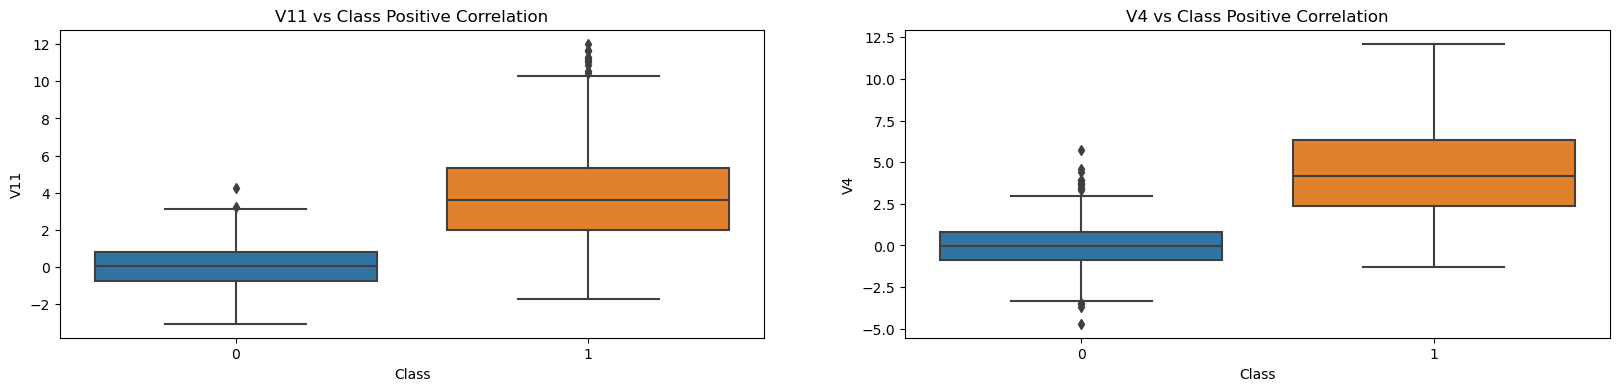

In [30]:
f, axes = plt.subplots(ncols=2,figsize=(20,4))


#Positive correlations (the higher the feature the probability of a fraud transaction increases)
sns.boxplot(x='Class',y='V11',data=new_df, ax = axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x='Class',y='V4',data=new_df, ax = axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

In [31]:
#Complete Line 2-16
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 =np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr =q75 - q25
print('iqr: {}'.format(v14_iqr))
v14_cut_off =v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

###################################################################################################################

v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

##################################################################################################################

v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-19.2143254902614, -18.8220867423816, -18.0499976898594, -18.4937733551053]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.0475965708216, -18.5536970096458, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-14.9246547735487, -15.124162

Text(0, -12, 'Fewer extreme \n outliers')

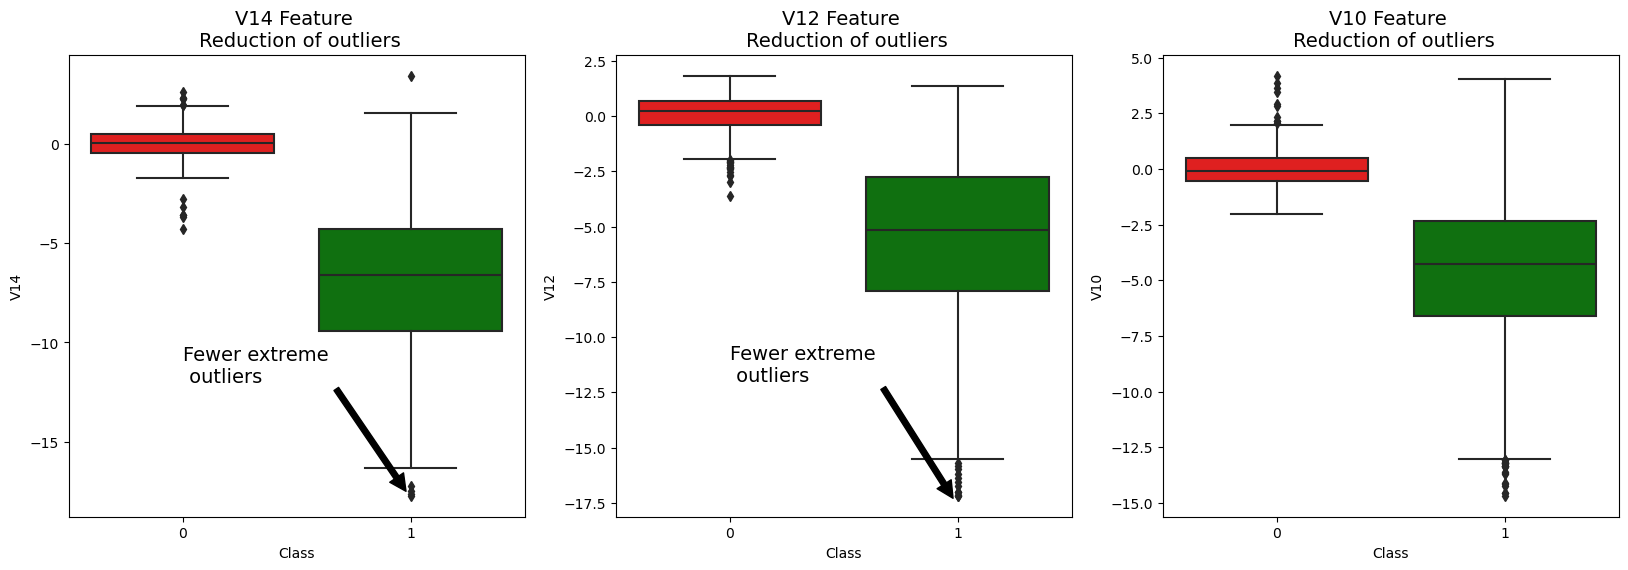

In [32]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6))

colors = ['red','green']

#feature V14
sns.boxplot(x='Class',y='V14',data=new_df,ax=ax1,palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),arrowprops=dict(facecolor='black'),fontsize=14)

#feature v12
sns.boxplot(x='Class',y='V12',data=new_df,ax=ax2,palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),arrowprops=dict(facecolor='black'),fontsize=14)

#feature V10
sns.boxplot(x='Class',y='V10',data=new_df,ax=ax3,palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),arrowprops=dict(facecolor='black'),fontsize=14)


<h1>DIMENSIONALITY REDUCTION VISUALIZATION</h1>

We have a data that is high dimensional and visualising any patterns in higher than 3 is not possible so to see how our data would look like we are going to use dimensionality reduction techniques for visualisation of our data, we are going to use.

TSNE
Principal Component Analysis(PCA)
Look at the given example and follow links given to complete the cell below

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

n_components(int): Dimension of the embedded spac, default=2.

In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

X = new_df.drop('Class',axis=1)
y = new_df['Class']

#TSNE implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)                      #### Complete this line ####
t1 = time.time()
print("T-SNE took {:.2} s".format(t1-t0))

#PCA implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)                       #### Complete this line ####
t1 = time.time()
print("PCA took {:.2} s".format(t1-t0))

#TruncatedSVD implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)                       #### Complete this line ####
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1-t0))

T-SNE took 9.9 s
PCA took 0.003 s
Truncated SVD took 0.016 s


As we plot are reduced dimension fetures we can see there is a decison boundary for model to learn visible in the 2-D projections.

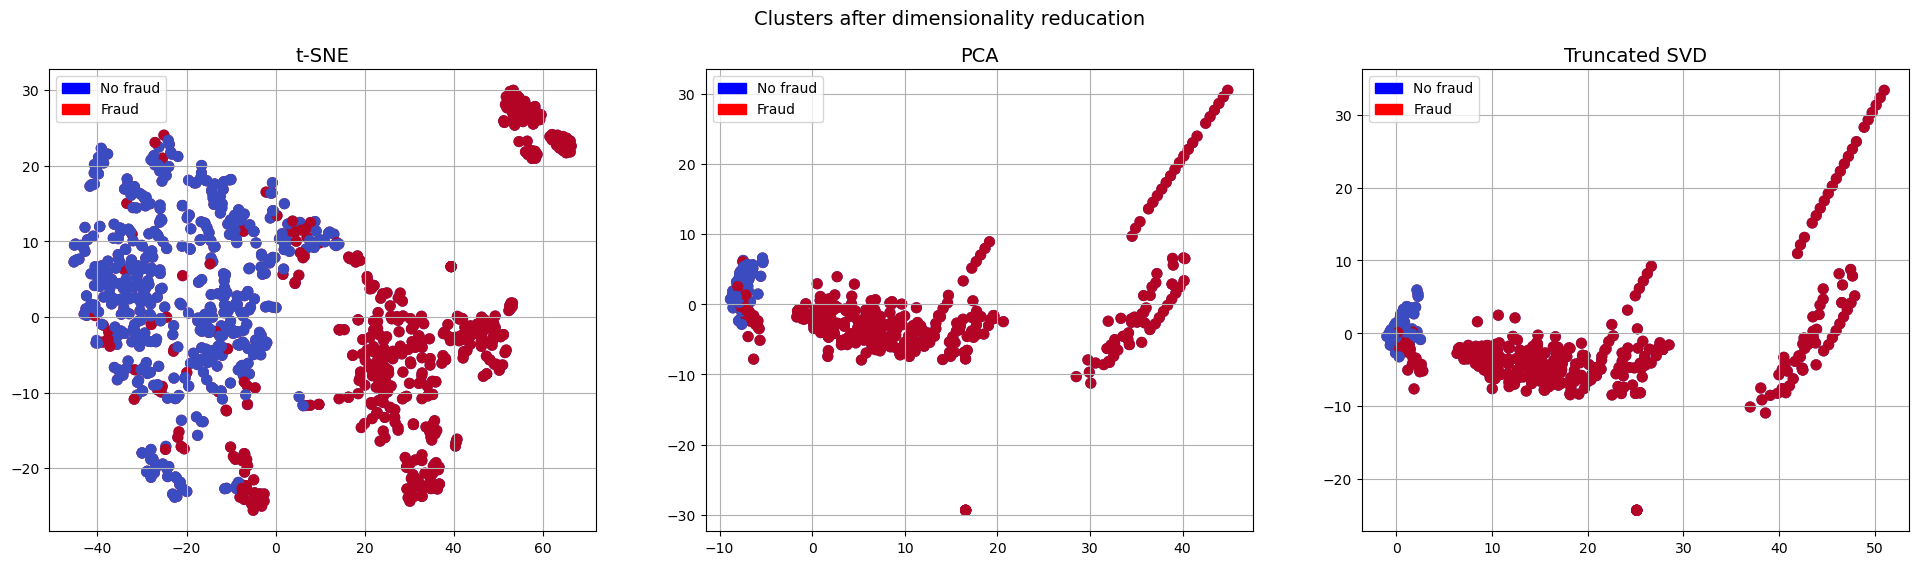

In [34]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,6))
f.suptitle('Clusters after dimensionality reducation',fontsize=14)

blue_patch = mpatches.Patch(color='blue',label = 'No fraud')
red_patch = mpatches.Patch(color='red',label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

<h1>IMPLEMENTING MODELS</h1>

In [35]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# SPLITTING IN TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
#converting to array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [37]:
print('X_shapes:\n', 'X_train:', 'X_test:\n', X_train.shape, X_test.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_test:\n', y_train.shape, y_test.shape)
X.columns

X_shapes:
 X_train: X_test:
 (756, 29) (189, 29) 

Y_shapes:
 Y_train: Y_test:
 (756,) (189,)


Index(['scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

As we have a classification problem on our hands we'll apply classification models and calculate the cross validation score to identify the best fit for our data.

Some of the models that we are going to use are.

* LogisticRegression
* KNeighborsClassifier
* Support Vector Classifier
* DecisionTreeClassifier

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [39]:
Models = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

We are going to use sklearn cross_val_score to compare model performances, for this we'll see which model has best mean average accuracy over given number of folds.



In [40]:
from sklearn.model_selection import cross_val_score


for key, classifier in Models.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifier: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifier:  LogisticRegression has a training score of 94.0 % accuracy score
Classifier:  KNeighborsClassifier has a training score of 93.0 % accuracy score
Classifier:  SVC has a training score of 93.0 % accuracy score
Classifier:  DecisionTreeClassifier has a training score of 90.0 % accuracy score


* Logistic regression appears to be working best for us.
Hyperparameter search using GridSearch

Now we try to look for the best set of paramters for models using gridsearch.

* follow the given syntax to execute the cell below for hyper-paramerter search.
params_dic = {hyper_param_1 : ['l1', 'l2'], hyper_param_2 : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf = GridSearchCV(LogisticRegression(), params_dic)
clf.fit(X, y)
log_reg = clf.best_estimator_

In [41]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
'''Steps:
    1. creating dict of parameters we are going to check
    2. applying grid search cv on our model and get model with best parameters
    3. Fit this new Model with X_train,y_train

'''

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [42]:
print(log_reg,'\n', knears_neighbors,'\n' ,svc,'\n', tree_clf)

LogisticRegression(C=1) 
 KNeighborsClassifier(n_neighbors=3) 
 SVC(C=0.5, kernel='linear') 
 DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)


Validation
Now we have our best set models trained using gridsearch now we move onto testing them on different metrices so as to know which one works best overall for us.

1. log_reg
2. knears_negihbors
3. svc
4. tree_clf
we'll evaluate model using:

* Cross_val_score
* ROC AUC Score
* ROC Curve
* Confusion Matrix, Classification report
* Average precison score, Area under precision recall curve

Now we find cross_validation scores for the models we got using GridsearchCV, use log_reg, knears_negihbors, svc and tree_clf in the below cell.

* Use the cross_val_score in the model training section to complete the code below.

In [43]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.18%
Knears Neighbors Cross Validation Score 93.52%
Support Vector Classifier Cross Validation Score 94.05%
DecisionTree Classifier Cross Validation Score 92.46%


SVC and Logistic regression have best cross validation score

let us also calculate roc_auc_score and also we will plot roc_curve, steps are as follows

get model predictions
pred = clf.predict(X_test)
*calculate ROC AUC Score

score = roc_aur_score(y_test, y_pred)
calculate *false positive rate(fpr), true positive rate(tpr) threshold and plot ROC curve using these.

fpr, tpr, thresold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Classifier Score: {:.4f}'.format(roc_auc_score(y_test, y_pred)))

In [44]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = log_reg.predict(X_test)

knears_pred = knears_neighbors.predict(X_test)

svc_pred = svc.predict(X_test)

tree_pred = tree_clf.predict(X_test)

In [45]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_test, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_test, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_test, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_test, tree_pred))

Logistic Regression:  0.9187883609911344
KNears Neighbors:  0.9329393043873608
Support Vector Classifier:  0.9235053421232099
Decision Tree Classifier:  0.9227097067515345


Plotting

In [46]:
log_fpr, log_tpr, log_thresold = roc_curve(y_test, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)

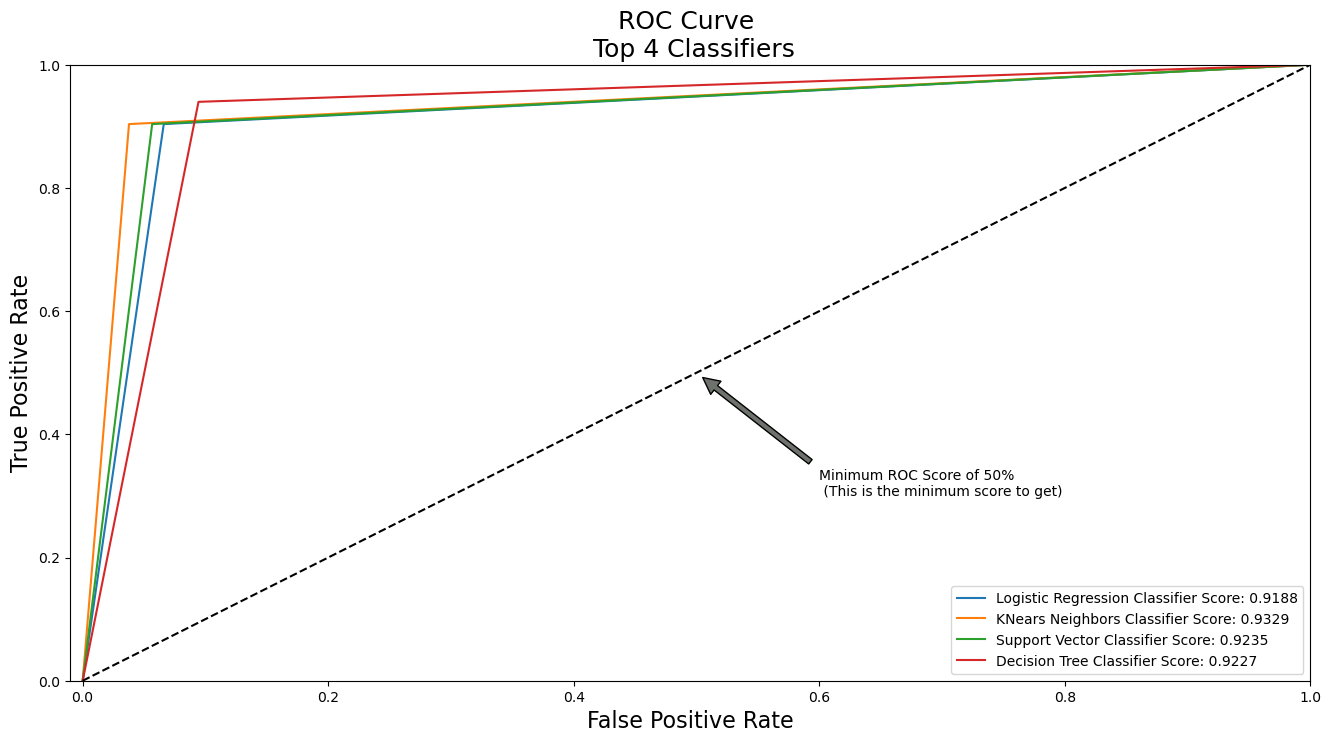

In [47]:
plt.figure(figsize=(16,8))
plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, log_reg_pred)))
plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_test, knears_pred)))
plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_test, tree_pred)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()

SVC has better ROC AUC Score and we can see that from the Curve as well, it is the best model till now.

We Now calculate confusion matrix and classification report to do some quantitative evaluation on validation set.

* follow the syntax below to calculate confusion matrix in the next cell.

cf = confusion_matrix(y_test, y_pred)

* We'll be validating our models on the "X_test" dataset we spared in train test split, so this is what our data looks like,

X_shapes: X_train, X_test:(756, 29) (190, 29)

Y_shapes: Y_train, Y_test: (756,) (190,)

y_test fraud and non-fraud data points respectively 86, 104.

[[99  7]
 [ 8 75]]
[[102   4]
 [  8  75]]
[[100   6]
 [  8  75]]
[[96 10]
 [ 5 78]]


[Text(0, 0.5, ''), Text(0, 1.5, '')]

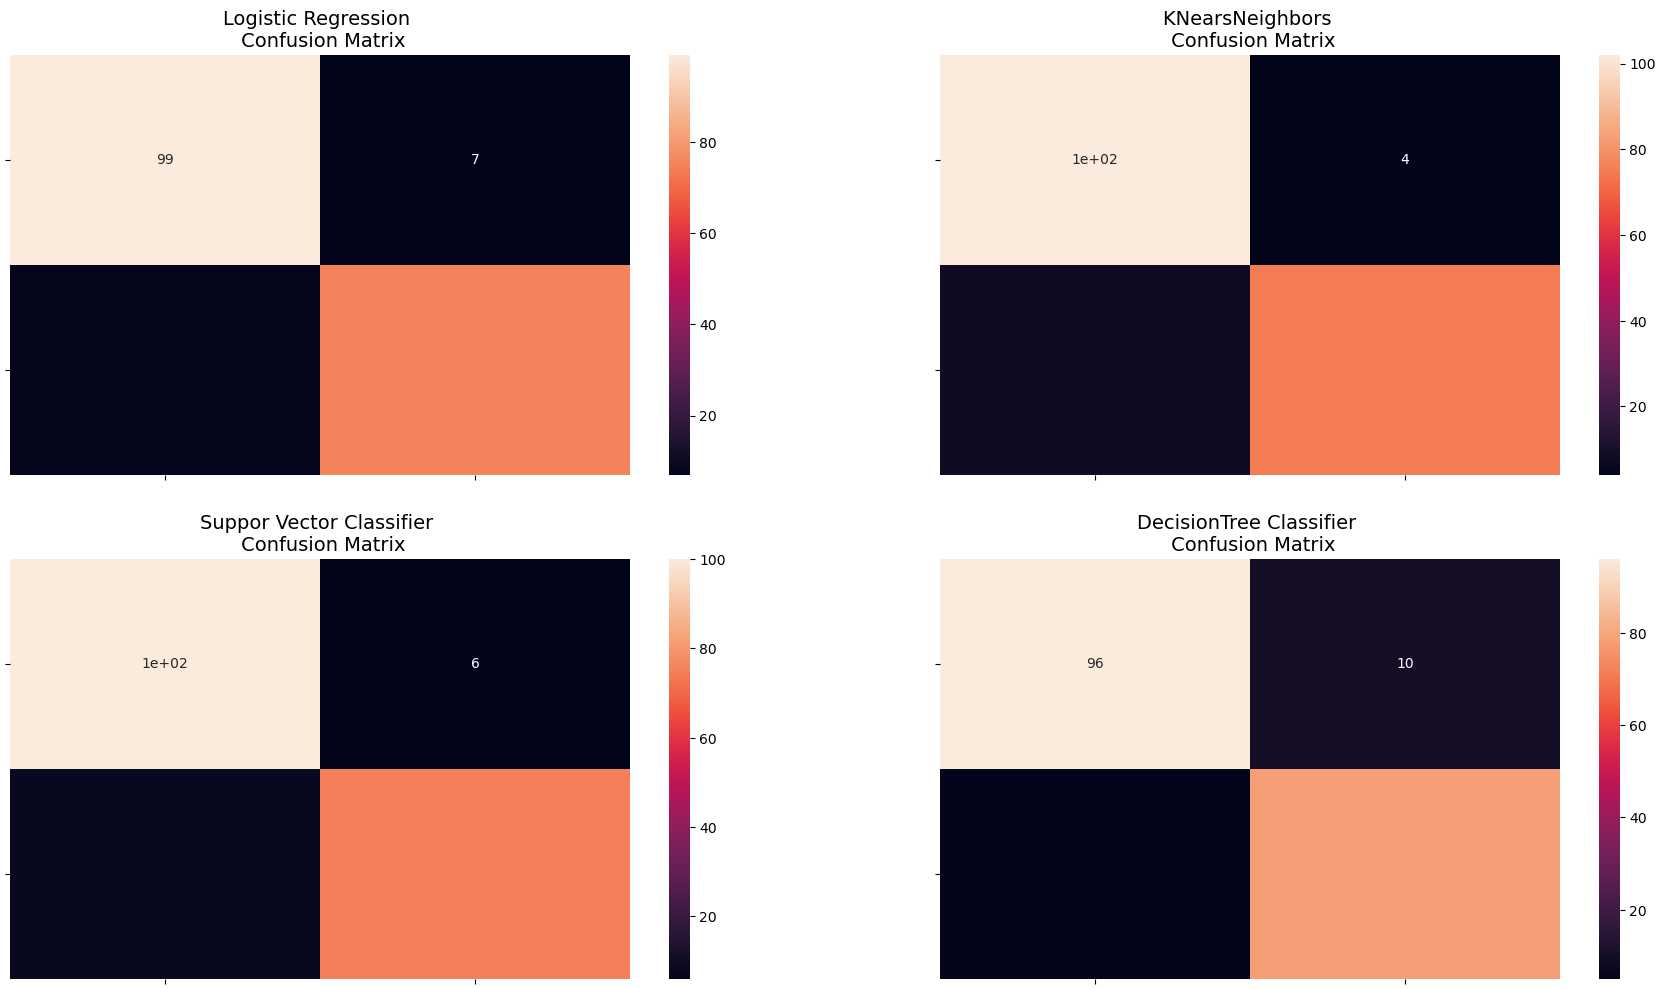

In [48]:
from sklearn.metrics import confusion_matrix
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)
print(log_reg_cf)
print(kneighbors_cf)
print(svc_cf)
print(tree_cf)


fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)
sns.heatmap(tree_cf, ax=ax[1][1], annot=True)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

Confusion matrix heatmaps above shows how our model doing on validation set from undersampled data, confusion matrix works as shown below

As we can see from the image above values in the squares along horizontal axis are the true values of a class and cells along vertical axis contains predicted values

As from above discussion we now know what our values in the cofusion matrix above stand for so now we'll calculate precision and recall for each classes.

* Precision = True Positive / (True Positive + False Positive)
* Recall = True Positive / (True Positive + False Negative)
* F1-Score = (2 * Precision * Recall) / (Precision + Recall)

It's evident that we need to look at recall to judege best performing model since we want to reduce False negatives for class 1(fraud).

In [49]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       106
           1       0.91      0.90      0.91        83

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       106
           1       0.95      0.90      0.93        83

    accuracy                           0.94       189
   macro avg       0.94      0.93      0.94       189
weighted avg       0.94      0.94      0.94       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       106
           1       0.93      0.90      0.91        83

    accuracy                           0.93       189
   macro avg       0.93      0.92      0.92       189
weighted

<h1>Testing </h1>

Now we'll test our models on original test data "original_Xtest".

First of all let's see confusion matrix for all our models.

* Taking predictions from logistic regression model, go ahead and complete the below cell to calculate these.

org_log_reg_pred = log_reg.predict(original_Xtest)

In [ ]:
org_log_reg_pred = log_reg.predict(original_Xtest)

org_knears_pred = knears_neighbors.predict(original_Xtest)

org_svc_pred = svc.predict(original_Xtest)

org_tree_pred = tree_clf.predict(original_Xtest)

and now we see confusion atrix for the same, refer to the syntax below and complete the next cell.

* calculating confusion matrix for logistic regression.

org_log_reg_cf = confusion_matrix(original_ytest, org_log_reg_pred)

In [ ]:
org_log_reg_cf = confusion_matrix(original_ytest, org_log_reg_pred)
org_kneighbors_cf = confusion_matrix(original_ytest, org_knears_pred)
org_svc_cf = confusion_matrix(original_ytest, org_svc_pred)
org_tree_cf = confusion_matrix(original_ytest,org_tree_pred)

print(org_log_reg_cf, '\n', org_kneighbors_cf, '\n', org_svc_cf, '\n', org_tree_cf )

SVC has least False negatives as expected for fraud class.

let's have a look at the classification report of the models.

as we can see other models have comapreable or better numbers in F1 or precision but that is not the judging criteria for us our recall of fraud class is what concerns us the most and that we have best for SVC.

In [ ]:
print('Logistic Regression:')
print(classification_report(original_ytest, org_log_reg_pred))

print('KNears Neighbors:')
print(classification_report(original_ytest, org_knears_pred))

print('Support Vector Classifier:')
print(classification_report(original_ytest, org_svc_pred))

print('Tree Classifier:')
print(classification_report(original_ytest, org_tree_pred))

Observations:

The classification reports provide detailed information about the models' performance, including precision, recall, F1-score, and support for each class.
The SVC model has the highest recall for the positive class (fraud), indicating that it correctly identifies the most fraudulent transactions.
The other models have comparable or better numbers in precision or F1-score, but the SVC model's superior recall for the positive class makes it the best choice for this specific problem.

Conclusion:

Based on the confusion matrices and classification reports, the SVC model is the best performer for credit card fraud detection in this case, as it has the highest recall for the positive class (fraud). This means that it correctly identifies the most fraudulent transactions, which is the most important factor for this problem.